In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import Flow_solutions as FS
import mass_loss_functions as mlf
import params as prm

In [2]:
%matplotlib widget

In [3]:
# model parameters
m_planet_list = [0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] # planet mass
water_percent_list = [x/10 for x in range(1, 81)] # WMF

radii_list = []
mass_list = []
teq_list = []

# model
for m_planet in m_planet_list:
    for wmf in water_percent_list:

        model = os.path.join('/Users/mvalatsou/PhD/Repos/MR_perplex/OUTPUT/CW/critical_WMF/gridmin295/', f'M{m_planet}W{wmf}_p_T_g_r_m_rho.ddat')

        if os.path.exists(model):
            with open(model, 'r') as file:
                lines = file.readlines()
                pressure_row = lines[1].strip().split()
                temperature_row = lines[2].strip().split()
                radius_row = lines[4].strip().split()
                mass_row = lines[5].strip().split()
                density_row = lines[6].strip().split()
                phase_id_row = lines[-1].strip().split() 

            pressure = np.array([float(value) for value in pressure_row[-400:]]) # in barye
            temperature = np.array([float(value) for value in temperature_row[-400:]])
            r_planet = np.array([float(value) for value in radius_row[-400:]])
            m_planet = np.array([float(value) for value in mass_row[-400:]])
            density = np.array([float(value) for value in density_row[-400:]])

            r_planet = r_planet[-1] # planet radius, cm.
            m_planet = m_planet[-1] # planet mass in grams. Earth mass = 5.97424E+27 from M-R code
            Teq = temperature[-1]   # equilibrium temperature, K.
            # Teq = 2000

            radii_list.append(r_planet)
            mass_list.append(m_planet)
            teq_list.append(Teq)

REUV = np.logspace(8, 11, num=100)
cs_out = np.zeros(np.size(REUV)) # sound speet at REUV

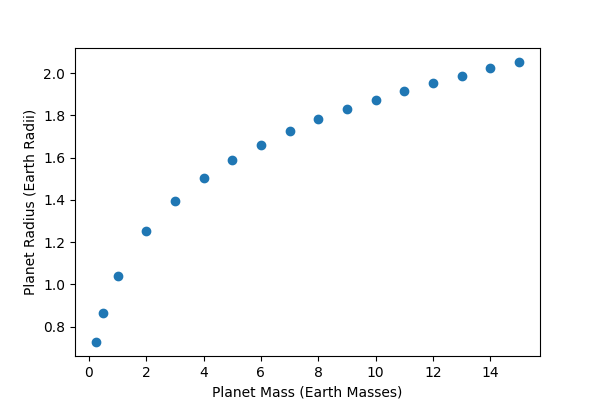

In [4]:
# check that data is read properly
rearth = prm.rearth     # Radius earth in cgs
mearth = prm.mearth     # Mass earth in cgs

mass_array = np.array(mass_list)
radius_array = np.array(radii_list)

mass_in_earth_masses = mass_array / mearth
radius_in_earth_radii = radius_array / rearth

plt.figure(figsize=(6, 4))
plt.scatter(mass_in_earth_masses, radius_in_earth_radii)
plt.xlabel('Planet Mass (Earth Masses)')
plt.ylabel('Planet Radius (Earth Radii)')
plt.show()

In [5]:
results = []

for m_planet, r_planet, Teq in zip(mass_list, radii_list, teq_list):
    FEUV = prm.FEUV
    alpha_rec = prm.alpha_rec       # recombination coefficient, cm^3/s, hard-coded as a number in James' code
    E_photon = prm.E_photon         # average energy per EUV photon, erg (assuming 20 eV per photon)
    FEUV_photon = FEUV / E_photon   # convert FEUV from erg/cm^2/s to photons/cm^2/s
    G = prm.G
    k_b = prm.k_b
    mmw_eq = prm.mmw_eq
    m_H = prm.m_H
    kappa_p = prm.kappa_p
    g = G * m_planet / r_planet**2              # gravity at planet surface (?)
    Fbol = 4. * 5.6705e-5 * Teq**4.             # bolometric flux (across all wavelengths), erg cm-2 s-1
    cs_eq = np.sqrt((k_b * Teq)/(m_H * mmw_eq)) # isothermal (at T_eq) sound speed
    rho_photo = g / (kappa_p * cs_eq**2)        # photospheric density in g cm-3
    
    result = {'m_planet': m_planet, 'r_planet': r_planet, 'Teq': Teq,}

    try:
        REUV_solution_EL, time_scale_ratio = mlf.find_REUV_solution_EL(r_planet, m_planet, rho_photo, cs_eq, FEUV_photon)
        print(f"REUV (EL): {REUV_solution_EL:.4e} cm")
        cs_use = mlf.compute_sound_speed(REUV_solution_EL, m_planet)
        cs_use = min(cs_use, 1.2e6)
        print(f"Sound speed: {cs_use:.4e} cm/s")
        Mdot = mlf.compute_mdot_only(cs_use, REUV_solution_EL, m_planet)
        print(f"Mass-loss rate: {Mdot:.4e} g/s")
        
        # use EL values
        REUV_final = REUV_solution_EL
        cs_use_final = cs_use
        Mdot_final = Mdot

        result.update({
            'REUV_final': REUV_solution_EL,
            'cs_use_final': cs_use,
            'Mdot_final': Mdot,
            'time_scale_ratio': time_scale_ratio,
            'regime': 'EL',
        })
        
        if time_scale_ratio < 1:
            # recombination-limited regime is dominant
            REUV_solution_RL = mlf.find_REUV_solution_RL(r_planet, m_planet, rho_photo, cs_eq, FEUV_photon)
            print(f"REUV (RL): {REUV_solution_RL:.4e} cm")
            cs_use_RL = 1.2e6
            print(f"Sound speed: {cs_use_RL:.4e} cm/s")
            Hflow_RL = min(REUV_solution_RL / 3, cs_use_RL**2 * REUV_solution_RL**2 / (2 * G * m_planet))
            nb = np.sqrt(FEUV_photon / (alpha_rec * Hflow_RL))
            Rs_RL = G * m_planet / (2. * cs_use_RL**2)
            if REUV_solution_RL <= Rs_RL:
                u_RL = FS.get_parker_wind_single(REUV_solution_RL, cs_use_RL, Rs_RL)
            else:
                u_RL = cs_use_RL
            Mdot_RL = 4 * np.pi * REUV_solution_RL**2 * m_H * nb * u_RL
            print(f"Mass-loss rate: {Mdot_RL:.4e} g/s")
            
            # use RL values
            REUV_final = REUV_solution_RL
            cs_use_final = cs_use_RL
            Mdot_final = Mdot_RL

            result.update({
                'REUV_final': REUV_solution_RL,
                'cs_use_final': cs_use_RL,
                'Mdot_final': Mdot_RL,
                'time_scale_ratio': time_scale_ratio,
                'regime': 'RL',
            })

        results.append(result)

    except Exception as e:
        print(f"An error occurred with mass {m_planet} Earth masses: {e}")

REUV (EL): 5.0822e+08 cm
Sound speed: 1.5655e+05 cm/s
Mass-loss rate: 1.3962e+08 g/s
REUV (EL): 5.8267e+08 cm
Sound speed: 1.9431e+05 cm/s
Mass-loss rate: 1.0521e+08 g/s
REUV (EL): 6.8530e+08 cm
Sound speed: 2.4153e+05 cm/s
Mass-loss rate: 8.5608e+07 g/s
REUV (EL): 8.1471e+08 cm
Sound speed: 3.0090e+05 cm/s
Mass-loss rate: 7.1925e+07 g/s
REUV (EL): 9.0179e+08 cm
Sound speed: 3.4287e+05 cm/s
Mass-loss rate: 6.5004e+07 g/s


/Users/mvalatsou/PhD/Repos/massloss/mass_loss_functions.py:106: RuntimeWarning: divide by zero encountered in scalar divide
  diff = (rho_EUV * cs_eq**2 - rho_flow * (u_launch**2 + cs_use**2)) / (2. * rho_EUV * cs_eq**2)


REUV (EL): 9.6814e+08 cm
Sound speed: 3.7654e+05 cm/s
Mass-loss rate: 6.0328e+07 g/s
REUV (EL): 1.0220e+09 cm
Sound speed: 4.0521e+05 cm/s
Mass-loss rate: 5.6768e+07 g/s
REUV (EL): 1.0674e+09 cm
Sound speed: 4.3048e+05 cm/s
Mass-loss rate: 5.3901e+07 g/s
REUV (EL): 1.1069e+09 cm
Sound speed: 4.5319e+05 cm/s
Mass-loss rate: 5.1523e+07 g/s
REUV (EL): 1.1421e+09 cm
Sound speed: 4.7395e+05 cm/s
Mass-loss rate: 4.9519e+07 g/s
REUV (EL): 1.1730e+09 cm
Sound speed: 4.9326e+05 cm/s
Mass-loss rate: 4.7683e+07 g/s
REUV (EL): 1.2013e+09 cm
Sound speed: 5.1123e+05 cm/s
Mass-loss rate: 4.6095e+07 g/s
REUV (EL): 1.2267e+09 cm
Sound speed: 5.2819e+05 cm/s
Mass-loss rate: 4.4627e+07 g/s
REUV (EL): 1.2505e+09 cm
Sound speed: 5.4418e+05 cm/s
Mass-loss rate: 4.3332e+07 g/s
REUV (EL): 1.2726e+09 cm
Sound speed: 5.5936e+05 cm/s
Mass-loss rate: 4.2162e+07 g/s
REUV (EL): 1.2941e+09 cm
Sound speed: 5.7374e+05 cm/s
Mass-loss rate: 4.1158e+07 g/s
REUV (EL): 1.3130e+09 cm
Sound speed: 5.8767e+05 cm/s
Mass-loss r

In [6]:
df_results = pd.DataFrame(results)

df_results['m_planet_earth'] = df_results['m_planet'] / mearth

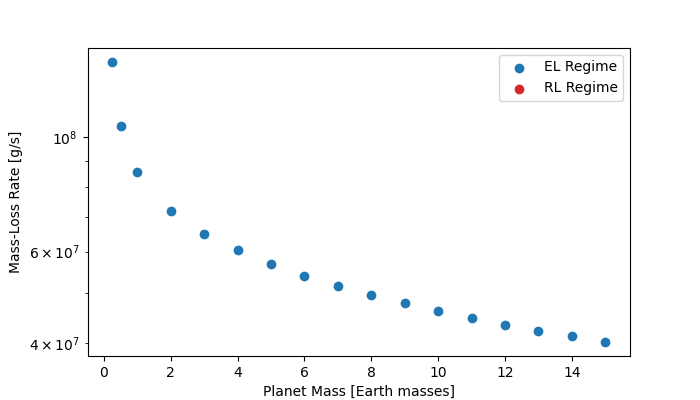

In [7]:
df_EL = df_results[df_results['regime'] == 'EL']
df_RL = df_results[df_results['regime'] == 'RL']

plt.figure(figsize=(7, 4))

plt.scatter(df_EL['m_planet_earth'], df_EL['Mdot_final'], color='tab:blue', label='EL Regime')
plt.scatter(df_RL['m_planet_earth'], df_RL['Mdot_final'], color='tab:red', label='RL Regime')

plt.xlabel('Planet Mass [Earth masses]')
plt.ylabel('Mass-Loss Rate [g/s]')
plt.yscale('log')

plt.legend()
plt.show()

##### For loss of O in H

In [8]:
T_REUV_list = []
x_O_list = []
phi_O_list = []

for result in results:
    m_planet = result['m_planet']   # g
    REUV = result['REUV_final']     # cm
    cs = result['cs_use_final']     # cm/s
    Mdot = result['Mdot_final']     # g/s

    mmw_H = prm.mmw_H
    m_O = prm.m_O
    T_REUV = (cs**2 * m_H * mmw_H) / k_b    # K

    b_i = 4.8e17 * T_REUV ** 0.75           # cm^-1 s^-1, Zahnle & Kasting 1986, Table 1
    mass_difference = m_O - m_H         # grams
    flux_total = Mdot / (4 * np.pi * REUV**2)  # g cm^-2 s^-1, total flux

    numerator = ((phi_H * REUV**2) / b_i) - ((G * m_planet * (mass_difference))/(k_b * T_REUV)) # Zahnle & Kasting 1986, equation 14
    denominator = numerator * np.exp(-numerator / REUV) # Zahnle & Kasting 1986, equation 14

    x_O = numerator/denominator # fractionation factor of O

    N_H = 1                     # Hydrogen reservoir
    N_O = N_H / 2               # For H2O, the reservoir of O is half of the reservoir of H
    reservoir_ratio = N_O / N_H # needed ratio if we solve for φ_k in eq.2 Zahnle & Kasting 1986

    phi_O = x_O * phi_H * reservoir_ratio # escape flux of oxygen, after eq.2 Zahnle & Kasting 1986

    T_REUV_list.append(T_REUV)
    x_O_list.append(x_O)
    phi_O_list.append(phi_O)

df_results['T_REUV'] = T_REUV_list
df_results['x_O'] = x_O_list
df_results['phi_O'] = phi_O_list

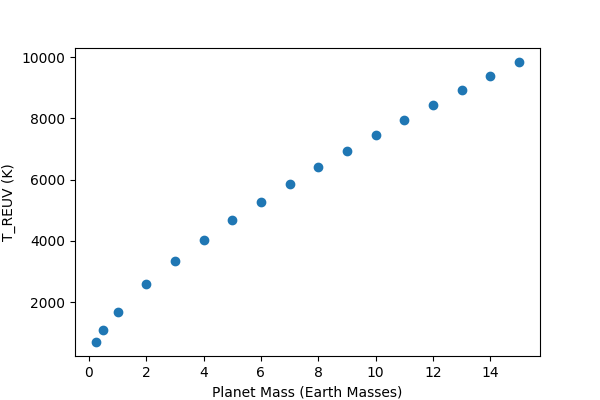

In [9]:
plt.figure(figsize=(6, 4))
plt.scatter(df_results['m_planet_earth'], df_results['T_REUV'])
plt.xlabel('Planet Mass (Earth Masses)')
plt.ylabel('T_REUV (K)')
plt.show()

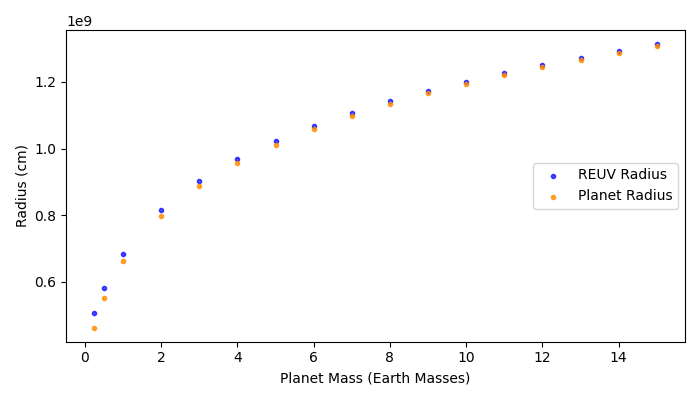

In [21]:
plt.figure(figsize=(7, 4))

color_radius = 'darkorange'
color_REUV = 'blue'

plt.scatter(df_results['m_planet_earth'], df_results['REUV_final'], color=color_REUV, alpha=0.7, marker='.', label='REUV Radius')
plt.scatter(df_results['m_planet_earth'], radii_list, color=color_radius, alpha=0.8, marker='.', label='Planet Radius')
plt.xlabel('Planet Mass (Earth Masses)')
plt.ylabel('Radius (cm)')
# plt.yscale('log')
# ax1.tick_params(axis='y')
plt.legend(loc='center right')

plt.tight_layout()
plt.show()

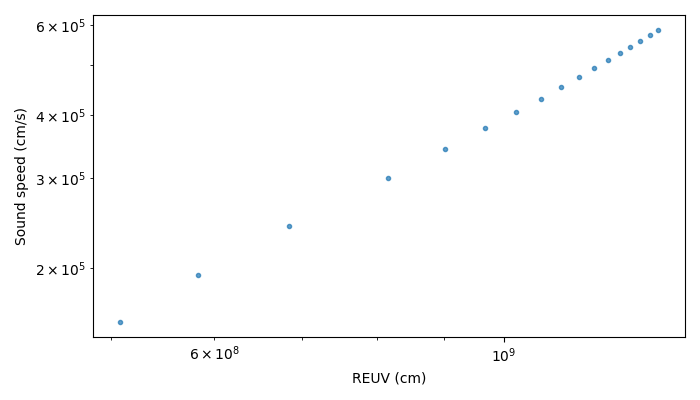

In [25]:
plt.figure(figsize=(7, 4))

plt.scatter(df_results['REUV_final'], df_results['cs_use_final'], alpha=0.7, marker='.')
plt.xlabel('REUV (cm)')
plt.ylabel('Sound speed (cm/s)')
plt.yscale('log')
plt.xscale('log')
# ax1.tick_params(axis='y')
for i in range(len(df_results['m_planet_earth'])):
    plt.annotate(f"{df_results['m_planet_earth'][i]:.1f}", 
                 (df_results['cs_use_final'][i], df_results['REUV_final'][i]),
                 textcoords="offset points", xytext=(0,5), ha='center', fontsize=5)

plt.tight_layout()
plt.show()

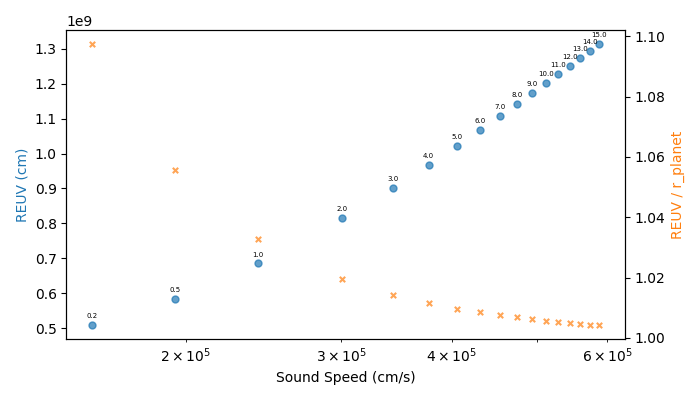

In [12]:
fig, ax1 = plt.subplots(figsize=(7, 4))

color1 = 'tab:blue'
ax1.scatter(df_results['cs_use_final'], df_results['REUV_final'], 
            color=color1, alpha=0.7, marker='.', s=100, label='REUV (cm)')
ax1.set_xlabel('Sound Speed (cm/s)')
ax1.set_ylabel('REUV (cm)', color=color1)
ax1.set_xscale('log')
# ax1.set_yscale('log')

ax2 = ax1.twinx()
color2 = 'tab:orange'
normalized_REUV = df_results['REUV_final'] / df_results['r_planet']
ax2.scatter(df_results['cs_use_final'], normalized_REUV, 
            color=color2, alpha=0.7, marker='x', s=15, label='REUV / r_planet')
ax2.set_ylabel('REUV / r_planet', color=color2)
# ax2.set_yscale('log')

for i in range(len(df_results['m_planet_earth'])):
    ax1.annotate(f"{df_results['m_planet_earth'][i]:.1f}", 
                 (df_results['cs_use_final'][i], df_results['REUV_final'][i]),
                 textcoords="offset points", xytext=(0,5), ha='center', fontsize=5)

plt.tight_layout()
plt.show()

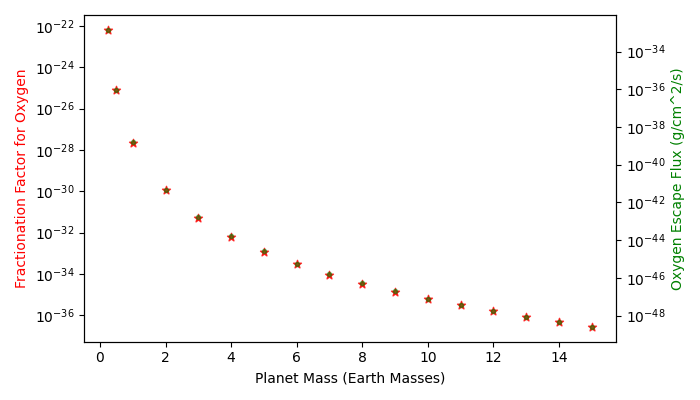

In [13]:
plt.figure(figsize=(7, 4))

ax1 = plt.gca()
color1 = 'red'
ax1.scatter(df_results['m_planet_earth'], x_O_list, color=color1, label='Fractionation Factor', alpha=0.8, marker='*')
ax1.set_xlabel('Planet Mass (Earth Masses)')
ax1.set_ylabel('Fractionation Factor for Oxygen', color=color1)
ax1.set_yscale('log')
# ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'green'
ax2.scatter(df_results['m_planet_earth'], phi_O_list, color=color2, label='Oxygen Escape Flux', alpha=0.5, marker='.')
ax2.set_ylabel('Oxygen Escape Flux (g/cm^2/s)', color=color2)
ax2.set_yscale('log')
# ax2.tick_params(axis='y', labelcolor=color2)

plt.tight_layout()
plt.show()

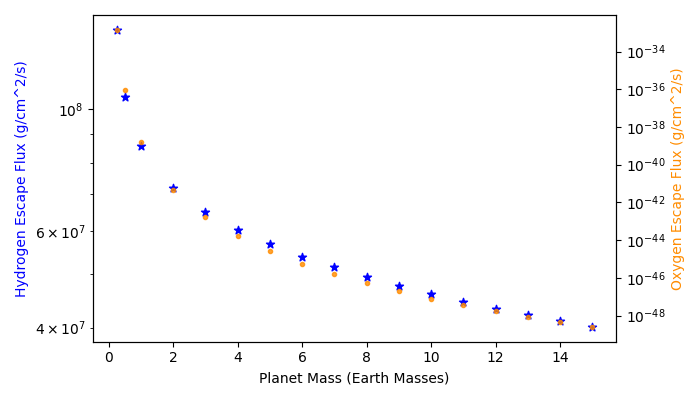

In [14]:
plt.figure(figsize=(7, 4))

ax1 = plt.gca()
color1 = 'blue'
ax1.scatter(df_results['m_planet_earth'], df_results['Mdot_final'], color=color1, alpha=1, marker='*')
ax1.set_xlabel('Planet Mass (Earth Masses)')
ax1.set_ylabel('Hydrogen Escape Flux (g/cm^2/s)', color=color1)
ax1.set_yscale('log')
# ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'darkorange'
ax2.scatter(df_results['m_planet_earth'], phi_O_list, color=color2, alpha=0.8, marker='.')
ax2.set_ylabel('Oxygen Escape Flux (g/cm^2/s)', color=color2)
ax2.set_yscale('log')
# ax2.tick_params(axis='y', labelcolor=color2)

plt.tight_layout()
plt.show()

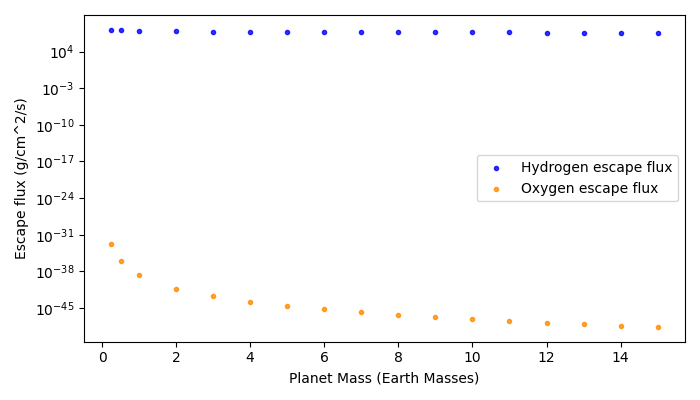

In [15]:
plt.figure(figsize=(7, 4))

color_radius = 'darkorange'
color_REUV = 'blue'

plt.scatter(df_results['m_planet_earth'], df_results['Mdot_final'], color=color_REUV, alpha=0.8, marker='.', label='Hydrogen escape flux')
plt.scatter(df_results['m_planet_earth'], phi_O_list, color=color_radius, alpha=0.8, marker='.', label='Oxygen escape flux')
plt.xlabel('Planet Mass (Earth Masses)')
plt.ylabel('Escape flux (g/cm^2/s)')
plt.yscale('log')
# ax1.tick_params(axis='y')
plt.legend(loc='center right')

plt.tight_layout()
plt.show()

In [16]:
ocean_mass = 1.35e24 # g
seconds_200Myr = 6.31152e15

total_mass_H_lost = Mdot * seconds_200Myr # g, in 200 Myr

In [17]:
# phi_O is a flux, so total mass-loss rate for O is
Mdot_O = phi_O * (4 * np.pi * REUV**2) # g/s

total_mass_O_lost = Mdot_O * seconds_200Myr # g
total_mass_H_plus_O_lost = total_mass_H_lost + total_mass_O_lost


In [18]:
# mass of one EO is about 1.35e24 g
oceans_H = total_mass_H_lost / ocean_mass
oceans_H_plus_O = total_mass_H_plus_O_lost / ocean_mass

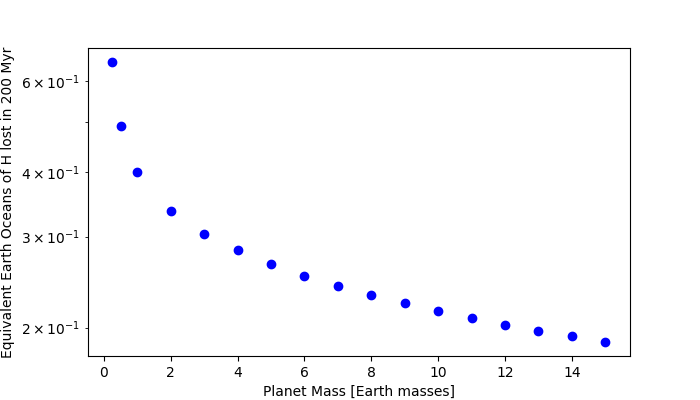

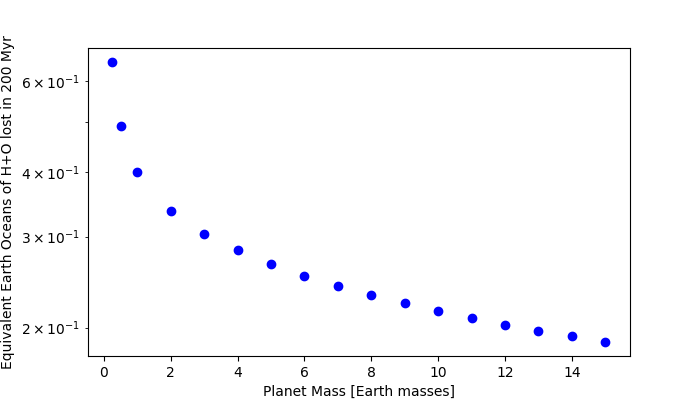

In [19]:
df_results['total_mass_H_lost'] = df_results['Mdot_final'] * seconds_200Myr
df_results['oceans_H'] = df_results['total_mass_H_lost'] / ocean_mass

df_results['Mdot_O'] = df_results.apply(lambda row: row['phi_O'] * (4 * np.pi * row['REUV_final']**2), axis=1)

# Compute total mass lost for O
df_results['total_mass_O_lost'] = df_results['Mdot_O'] * seconds_200Myr
df_results['total_mass_H_plus_O_lost'] = df_results['total_mass_H_lost'] + df_results['total_mass_O_lost']
df_results['oceans_H_plus_O'] = df_results['total_mass_H_plus_O_lost'] / ocean_mass

# Separate by regime for plotting
df_EL = df_results[df_results['regime'] == 'EL']
df_RL = df_results[df_results['regime'] == 'RL']

# Plot: Earth oceans equivalent of H lost vs planet mass
plt.figure(figsize=(7,4))
plt.scatter(df_EL['m_planet_earth'], df_EL['oceans_H'], color='blue', label='EL Regime (H only)')
plt.scatter(df_RL['m_planet_earth'], df_RL['oceans_H'], color='red', label='RL Regime (H only)')
plt.xlabel('Planet Mass [Earth masses]')
plt.ylabel('Equivalent Earth Oceans of H lost in 200 Myr')
plt.yscale('log')
plt.show()

# Plot: Earth oceans equivalent of H+O lost vs planet mass
plt.figure(figsize=(7,4))
plt.scatter(df_EL['m_planet_earth'], df_EL['oceans_H_plus_O'], color='blue', label='EL Regime (H+O)')
plt.scatter(df_RL['m_planet_earth'], df_RL['oceans_H_plus_O'], color='red', label='RL Regime (H+O)')
plt.xlabel('Planet Mass [Earth masses]')
plt.ylabel('Equivalent Earth Oceans of H+O lost in 200 Myr')
plt.yscale('log')
plt.show()
